In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


In [ ]:
seed=1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
batch_size = 64
learning_rate = 0.1

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
train_trans = transforms.Compose(
    [
     transforms.RandomResizedCrop((224,224)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)
    ]
)

val_trans = transforms.Compose(
    [
     transforms.Resize((224,224)),
     transforms.CenterCrop((224, 224)),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)
    ]
)

In [ ]:
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/train',
                                 transform=train_trans
                                 )

val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/val',
                                 transform=val_trans
                                 )

test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/test',
                                 transform=val_trans
                                 )

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)

In [ ]:
model = models.vgg16(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.classifier[6] = nn.Linear(in_features=4096, out_features=2)
model = model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
torch.cuda.empty_cache()

In [ ]:
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def train_loop (model, num_epochs, step_lr_scheduler, loss_train, loss_val, train_acc_hist, val_acc_hist, best_acc):

  for epoch in range(num_epochs):

      model.train()

      running_loss = 0.0
      running_corrects = 0

      for idx, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)
          z_scores = model(images)
          loss = criterion(z_scores, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * images.size(0)
          _, predictions = torch.max(z_scores, 1)
          running_corrects += torch.sum(predictions == labels)

      epoch_loss = running_loss / len(train_dataset)
      epoch_acc = running_corrects / len(train_dataset)
      print(f'Epoch {epoch+1} / {num_epochs}, '
            f'Train Loss {epoch_loss:.4f}, '
            f'Train Acc {epoch_acc:.4f}')

      train_acc_hist.append(epoch_acc)
      loss_train.append(epoch_loss)

      step_lr_scheduler.step()

      model.eval()

      running_loss = 0.0
      running_corrects = 0

      for idx, (images, labels) in enumerate(val_loader):
          images = images.to(device)
          labels = labels.to(device)

          with torch.no_grad():
              z_scores = model(images)
              loss = criterion(z_scores, labels)

              running_loss += loss.item() * images.size(0)
              _, predictions = torch.max(z_scores, 1)
              running_corrects += torch.sum(predictions == labels)

      epoch_loss_val = running_loss / len(val_dataset)
      epoch_acc_val = running_corrects / len(val_dataset)
      print(f'Epoch {epoch + 1} / {num_epochs}, '
            f'Val Loss {epoch_loss_val:.4f}, '
            f'Val Acc {epoch_acc_val:.4f}')

      val_acc_hist.append(epoch_acc_val)
      loss_val.append(epoch_loss_val)

      if epoch_acc_val > best_acc:
          best_acc = epoch_acc_val

In [ ]:
def calculate_time (time_elapsed):
    minutes = time_elapsed // 60
    seconds = time_elapsed % 60
    if minutes > 60:
        hours = minutes // 60
        new_minutes = minutes % 60
        print(f'Training complete in {hours:.0f}h {new_minutes:.0f}m {seconds:.0f}s')
    else:
        print(f'Training complete in {minutes:.0f}m {seconds:.0f}s')

In [ ]:
num_epochs = 50
val_acc_hist = []
train_acc_hist = []
loss_train = []
loss_val = []
best_acc = 0.0

In [ ]:
start = time.time()
train_loop(model, num_epochs, step_lr_scheduler, loss_train, loss_val, train_acc_hist, val_acc_hist, best_acc)
time_elapsed = time.time() - start

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 / 50, Train Loss 0.8088, Train Acc 0.4385
Epoch 1 / 50, Val Loss 0.7620, Val Acc 0.4839
Epoch 2 / 50, Train Loss 0.8218, Train Acc 0.4139
Epoch 2 / 50, Val Loss 0.7381, Val Acc 0.4624
Epoch 3 / 50, Train Loss 0.8296, Train Acc 0.4590
Epoch 3 / 50, Val Loss 0.7426, Val Acc 0.4839
Epoch 4 / 50, Train Loss 0.7651, Train Acc 0.4631
Epoch 4 / 50, Val Loss 0.7461, Val Acc 0.4731
Epoch 5 / 50, Train Loss 0.7971, Train Acc 0.4836
Epoch 5 / 50, Val Loss 0.7344, Val Acc 0.5484
Epoch 6 / 50, Train Loss 0.7800, Train Acc 0.4672
Epoch 6 / 50, Val Loss 0.7243, Val Acc 0.4731
Epoch 7 / 50, Train Loss 0.8032, Train Acc 0.4549
Epoch 7 / 50, Val Loss 0.7420, Val Acc 0.4624
Epoch 8 / 50, Train Loss 0.7774, Train Acc 0.5123
Epoch 8 / 50, Val Loss 0.7352, Val Acc 0.4839
Epoch 9 / 50, Train Loss 0.7740, Train Acc 0.5000
Epoch 9 / 50, Val Loss 0.7452, Val Acc 0.5161
Epoch 10 / 50, Train Loss 0.7781, Train Acc 0.4754
Epoch 10 / 50, Val Loss 0.7477, Val Acc 0.4624
Epoch 11 / 50, Train Loss 0.8014, Trai

In [ ]:
calculate_time(time_elapsed)

Training complete in 12m 45s


In [ ]:
print(f'Best validation Accuracy: {best_acc:.4f}')

Best validation Accuracy: 0.0000


In [ ]:
checkpoint = {
                'model_state_dict': model.state_dict(),
                'model_optimizer': optimizer.state_dict(),
                'val_acc_hist': val_acc_hist,
                'train_acc_hist': train_acc_hist,
                'loss_train': loss_train,
                'loss_val': loss_val,
                'best_acc': best_acc
}

torch.save(checkpoint, '/content/drive/MyDrive/vgg16_on_hymeno.pth')

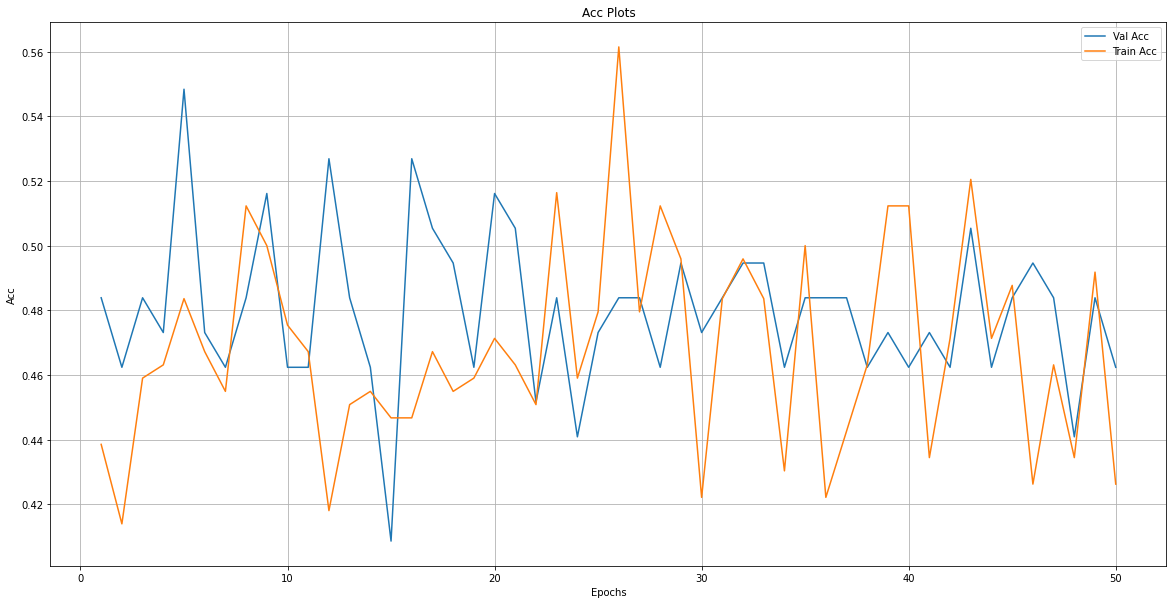

In [ ]:
val_acc_hist_numpy = [acc.cpu().numpy() for acc in val_acc_hist]
train_acc_hist_numpy = [acc.cpu().numpy() for acc in train_acc_hist]
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), val_acc_hist_numpy, label='Val Acc')
plt.plot(range(1, num_epochs+1), train_acc_hist_numpy, label='Train Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title("Acc Plots")
plt.legend(loc='upper right')
plt.show()

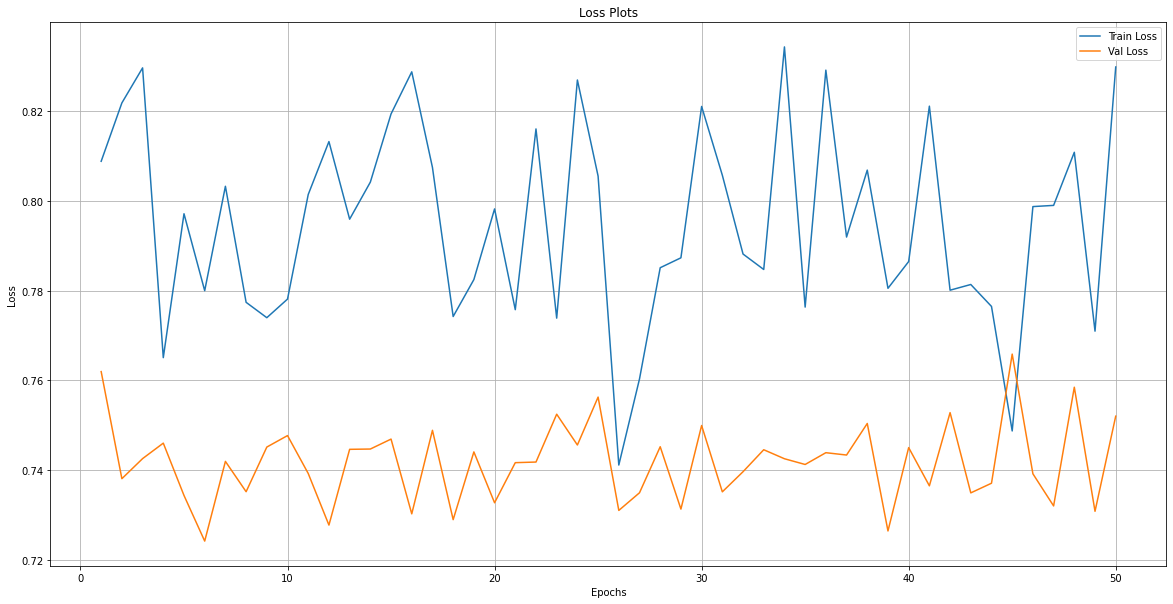

In [ ]:
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), loss_train, label='Train Loss')
plt.plot(range(1, num_epochs+1), loss_val, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [ ]:
model.eval()

running_corrects = 0

with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        z_scores = model(images)

        _, predictions = torch.max(z_scores,1)
        running_corrects += torch.sum(predictions == labels)

    acc = running_corrects / len(test_dataset)
    print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.5167


In [ ]:
from PIL import Image
img1 = Image.open('/content/drive/MyDrive/3421.jpg')
img2 = Image.open('/content/drive/MyDrive/ant-wood-grass-horse-Formica-insect.jpg')

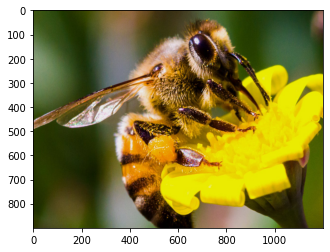

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img1)

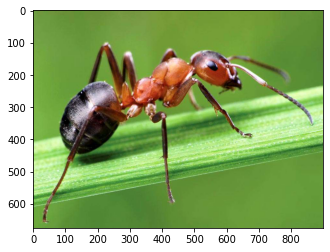

In [ ]:
plt.imshow(img2)

In [ ]:
img1 = train_trans(img1)
img2 = train_trans(img2)

In [ ]:
img1.shape

torch.Size([3, 224, 224])

In [ ]:
img1 = img1.unsqueeze(0)
img2 = img2.unsqueeze(0)
img1.shape

torch.Size([1, 3, 224, 224])

In [ ]:
model.eval()
img1 = img1.to(device)
z_score = model(img1)
_, prediction = torch.max(z_score,1)
print(f"The model predicts the img1's label is {prediction.item()}")

The model predicts the img1's label is 1


In [ ]:
model.eval()
img2 = img2.to(device)
z_score_2 = model(img2)
_, prediction_2 = torch.max(z_score_2,1)
print(f"The model predicts the img2's label is {prediction_2.item()}")

The model predicts the img2's label is 1
